## Imports

Prerequisites
* Install Python 3.12. At the time this was written, PyTorch did not support Python versions higher than 3.12.
* Create a virtual environment: `python -m venv .venv`.
* Activate the virtual environment: `.venv\Scripts\activate`
* Install required Python packages. Either
  * Use the latest versions: `pip install numpy matplotlib torch torchsummary ipykernel ipympl`
  * Use the versions frozen in requirements.txt: `pip install -r requirements.txt`

Let's import some packages that will be used throught this notebook.

In [1]:
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt

# Sample Function

Let's define a simple function `f(x)` that we'd like to approximate. We'll take `n` samples uniformly spaced along the x-axis in the range from `(x0, x1)` and store the x and y coordinates in the variables `x`, and `y`,

Note that if you change the definition of `f(x)`, you may also have to adjust `x0`, `x1`, and `n` to get a representative
set of samples over an interesting domain.

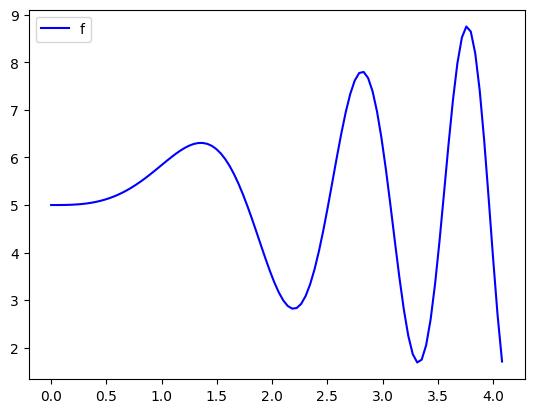

In [2]:
f = lambda x: np.sin(x**2) * x + 5
# f = lambda x: np.sin(x) + 5

x0 = 0    # Left side of domain
x1 = 4    # Right side of domain
n = 100   # Number of samples

x = np.linspace(x0, x1 + (x1 - x0) * 2 / n, n + 2)
y = np.vectorize(f)(x)

plt.plot(x, y, label="f", color="blue")
plt.legend()
plt.show()

# Piecewise-Linear Approximation

We'll use a naive algorithm to generate a continuous, piecewise linear function that approximates `f(x)`, with a bias towards shorter line segments in regions where the slope of `f(x)` changes more rapidly.

This approximation will be stored in `segments`.

Note that if you change the definition of `f(x)` you may need to adjust the `error_total` and `error_max` parameters to get a decent approximation.

Approximating function f(x) with 32 linear segments.


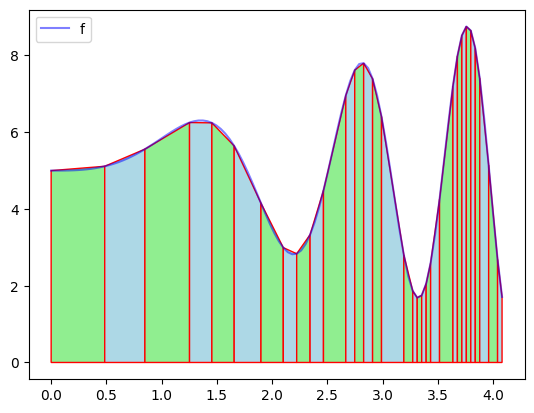

In [3]:
def compute_errors(x, y, i, j):
    if j - i == 1:
        return (0, 0, 0)
    m = (y[j - 1] - y[i]) / (x[j - 1] - x[i])
    b = y[i]
    errors = [abs((m * (x[k] - x[i])) + b - y[k]) for k in range(i, j)]
    return np.mean(errors), np.sum(errors), np.max(errors)


# Finds the longest run where the average error is less than epsilon
def next_piece(x, y, epsilon_total, epsilon_max, i):
    best_piece = None
    j = i + 1
    while j <= len(x):
        error = compute_errors(x, y, i, j)
        mean, total, max = error
        
        if total > epsilon_total:
            break
        if max > epsilon_max:
            break
        best_piece = (i, j, error)
        j += 1
    return best_piece


def piecewise(x, y, epsilon_total, epsilon_max, pieces):
    i = 0
    while i < len(x) - 1:
        piece = next_piece(x, y, epsilon_total, epsilon_max, i)
        pieces.append(piece)
        i = piece[1] - 1
    return pieces


# segments = piecewise(x, y, 0.05, [])
segments = piecewise(x, y, 0.35, .1, [])

fig, ax = plt.subplots()
for i, s in enumerate(segments):
    vertices = [
        (x[s[0]], 0),
        (x[s[0]], y[s[0]]),
        (x[s[1] - 1], y[s[1] - 1]),
        (x[s[1] - 1], 0),
    ]
    color = "lightgreen" if i % 2 == 0 else "lightblue"
    polygon = patches.Polygon(
        vertices, closed=True, fill=True, edgecolor="r", facecolor=color
    )
    ax.add_patch(polygon)

print(f"Approximating function f(x) with {len(segments)} linear segments.")

plt.plot(x, y, label="f", color="blue", alpha=0.5)
# plt.scatter([x[s[0]] for s in segments], [y[s[0]] for s in segments], color="red", label="Training samples")
plt.legend()
plt.show()

## Building a deep learning model to approximate `f(x)`

We can get a good approximation of `f(x)` using a model with two [dense layers](https://en.wikipedia.org/wiki/Layer_(deep_learning)), the first of which will use [RELU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation.

Let's create a a function to compute the weights and biases for this model. Given 
* **x:** samples of the domain of function `f(x)`
* **y:** corresponding values of `f(x)`
* **segments:** an array of `n` ranges of indices into `x` and `y`. Each range defines the extent of a single line segment.

Returns
* **m1:** a `1 x 2n` matrix of weights for the first layer
* **b1:** a `1 x 2n` vector of biases for the first layer
* **m2:** a `2n x 1` matrix of weights for the second layer
* **b2:** a `1 x 1` vector containing the single bias value for the second layer

In [4]:
def weights_and_biases(x, y, segments):
  m1 = []
  b1 = []
  m2 = []

  for s in segments:
    start = x[s[0]]
    slope = (y[s[1] -1] - y[s[0]]) / (x[s[1] - 1] - x[s[0]])
    end = x[s[1] - 1]

    if (slope >= 0):
      m1.append(slope)
      b1.append(-slope * start)
      m2.append(1)

      m1.append(slope)
      b1.append(-slope * end)
      m2.append(-1)
    else:
      m1.append(-slope)
      b1.append(slope * start)
      m2.append(-1)

      m1.append(-slope)
      b1.append(slope * end)
      m2.append(1)
  b2 = [y[segments[0][0]]]
  return m1, b1, m2, b2

Let's use these weights and biases to construct a Python function that implements the model. The plot shows the result of the model along with the original function `f(x)`.

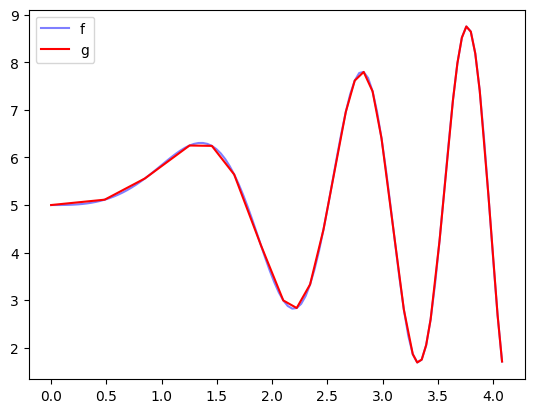

In [5]:
def build_python_model(wb):
  def relu(x):
    return max(0.0, x)

  m1, b1, m2, b2 = wb

  def f(x):
    layer1 = [relu(m1[i] * x + b1[i]) for i in range(len(m1))]
    sum = b2[0]
    for i in range(0, len(layer1)):
        sum += layer1[i] * m2[i]
    return sum
  
  return f

g = build_python_model(weights_and_biases(x, y, segments))

y2 = np.vectorize(g)(x)

plt.plot(x, y, label="f", color="blue", alpha=0.5)
plt.plot(x, y2, label="g", color="red")
plt.legend()
plt.show()

Let's write some utiltiies to help evaluate the model.

In [6]:
"""
A class to generate unique random floats within a range.
We will use this class to generate training, validation, and evaluation data.
"""
class UniqueRandomFloatGenerator:
    def __init__(self, low, high, precision=5):
        """
        Initialize the generator with a range and precision.
        
        :param low: The lower bound of the range.
        :param high: The upper bound of the range.
        :param precision: The precision (decimal places) for uniqueness.
        """
        self.low = low
        self.high = high
        self.precision = precision
        self.generated = set()
    
    def next(self, n):
        samples = []
        for _ in range(n):          
            sample = self.next_sample()
            samples.append(sample)
        return samples

    def next_sample(self):
        """
        Generate a unique random sample from the range.
        
        :return: A unique float within the specified range.
        """
        while True:
            # Generate a random float in the range
            sample = round(np.random.uniform(self.low, self.high), self.precision)
            # Check if it's unique
            if sample not in self.generated:
                self.generated.add(sample)
                return sample

# Generates n samples of f(x) for values of x between x0 and x1
# Sample has gaussian noise with standard deviation std_dev
def sample(f, x, std_dev = 0):
    y = np.vectorize(f)(x)
    noise = np.random.normal(0, std_dev, len(x)) if std_dev > 0 else 0
    return x, y + noise

generator = UniqueRandomFloatGenerator(x[0], x[-1])
evaluation = sample(f, generator.next(100))

def evaluate(samples, model):
  x, y = samples
  y2 = np.vectorize(model)(x)
  error = [abs(y2[i] - y[i]) for i in range(len(x))]
  return np.mean(error), np.sum(error), np.max(error)

print(f"mean error for f(x): {evaluate(evaluation, f)[0]}")
print(f"mean error for g(x): {evaluate(evaluation, g)[0]}")

mean error for f(x): 0.0
mean error for g(x): 0.03262497057531585


# PyTorch Model

Now let's use the same weights and biases to create a [PyTorch](https://pytorch.org/) model.

mean error for model_fun(x): 0.07802569036916875


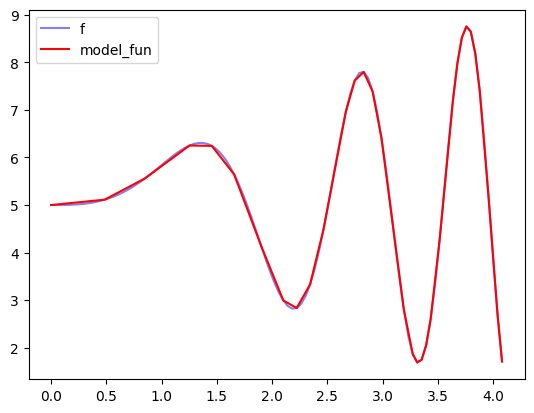

In [14]:
import torch
import torch.nn as nn
from torchsummary import summary

# torch.backends.cudnn.deterministic = True
torch.set_default_device("cpu")

class PyTorchModel(nn.Module):
    def __init__(
        self,
        wb,
    ):
        super(PyTorchModel, self).__init__()

        (w1, b1, w2, b2) = wb
        input_size = 1
        hidden_size = len(b1)
        output_size = 1

        # Define two linear layers
        self.layer1 = nn.Linear(input_size, hidden_size, dtype=torch.float64)
        self.layer2 = nn.Linear(hidden_size, output_size, dtype=torch.float64)

        # Initialize weights using the arrays provided
        self.layer1.weight = nn.Parameter(
            torch.tensor([[w] for w in w1], dtype=torch.float64)
        )
        self.layer1.bias = nn.Parameter(torch.tensor([b1], dtype=torch.float64))
        self.layer2.weight = nn.Parameter(torch.tensor([w2], dtype=torch.float64))
        self.layer2.bias = nn.Parameter(torch.tensor([b2], dtype=torch.float64))

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.layer2(x)
        return x



model = PyTorchModel(weights_and_biases(x, y, segments))


# Print the model summary
# Disabled because of
# RuntimeError: mat1 and mat2 must have the same dtype, but got Float and Double
# summary(model, (1, 1))

model_fun  = lambda x: model(torch.tensor([[x]], dtype=torch.float64)).item()
print(f"mean error for model_fun(x): {evaluate(evaluation, model_fun)[0]}")

y3 = np.vectorize(model_fun)(x)

plt.plot(x, y, label="f", color="blue", alpha=0.5)
plt.plot(x, y3, label="model_fun", color="red")
plt.legend()
plt.show()

Let's compare our Python model with the PyTorch model. They should be identical.

See this note on [PyTorch numerical accuracy](https://pytorch.org/docs/stable/notes/numerical_accuracy.html).

ERROR: next value should be zero or closer to zero
5.819403650869615 - 5.819403650869615: 0.0
3.57019455079997 - 3.57019455079997: 0.0
3.8888996547189336 - 3.8888996547189336: 0.0
1.708928721403936 - 1.70892872137847: 5.820766091346741e-11
total error for abs(g(x) - model_fun(x)): (np.float64(0.0), np.float64(0.0), np.float64(0.0))
total error for abs(g(x) - model_fun(x)): (np.float64(5.240252676230739e-16), np.float64(5.240252676230739e-14), np.float64(7.105427357601002e-15))


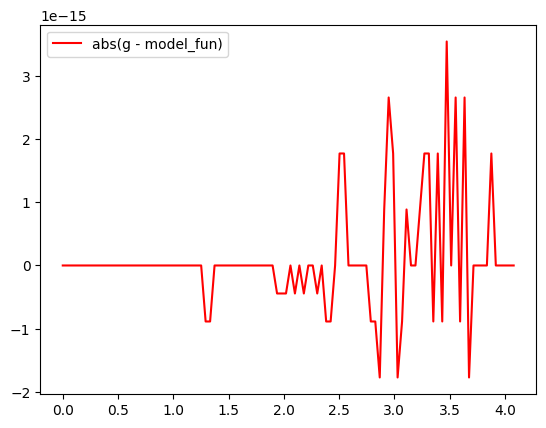

In [8]:
# deltas = (evaluation[0], [abs(y3[i] - evaluation[1][i]) for i in range(len(evaluation[0]))])
xq = [1]
yq = [g(1)]
print("ERROR: next value should be zero or closer to zero")
print(f"{g(1)} - {model_fun(1)}: {g(1) - model_fun(1)}")
print(f"{g(2)} - {model_fun(2)}: {g(2) - model_fun(2)}")
print(f"{g(4)} - {model_fun(4)}: {g(4) - model_fun(4)}")
print(f"{g(10000)} - {model_fun(1000)}: {g(10000) - model_fun(10000)}")
print(f"total error for abs(g(x) - model_fun(x)): {evaluate((xq, yq), model_fun)}")
print(f"total error for abs(g(x) - model_fun(x)): {evaluate((evaluation[0], np.vectorize(g)(evaluation[0])), model_fun)}")


plt.plot(x, y2 - y3, label="abs(g - model_fun)", color="red")
plt.legend()
plt.show()


The two functions look identical near the origin


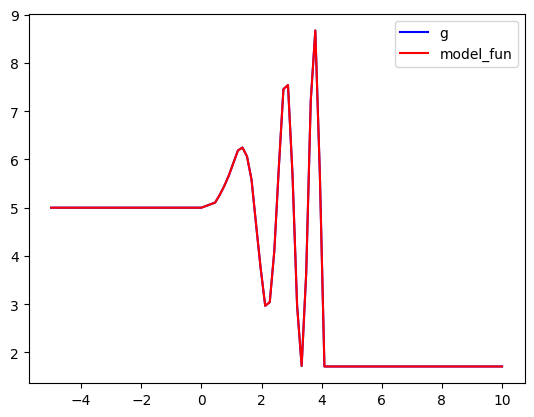

Two functions diverge further from the origin


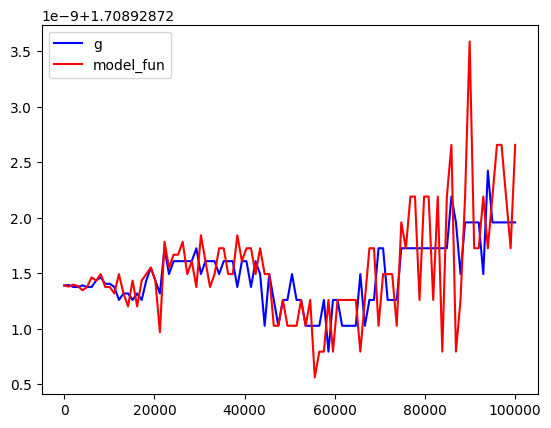

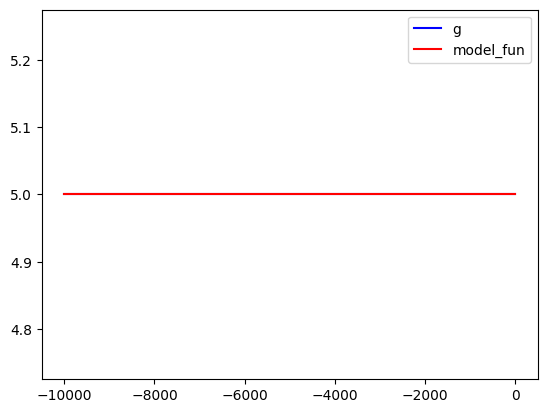

In [9]:
print("The two functions look identical near the origin")
# qx = np.linspace(100, 10000, 100)
qx = np.linspace(-5, 10, 100)
qyg = np.vectorize(g)(qx)
qym = np.vectorize(model_fun)(qx)

plt.plot(qx, qyg, label="g", color="blue")
plt.plot(qx, qym, label="model_fun", color="red")
plt.legend()
plt.show()

print("Two functions diverge further from the origin")
qx = np.linspace(5, 100000, 100)
qyg = np.vectorize(g)(qx)
qym = np.vectorize(model_fun)(qx)

plt.plot(qx, qyg, label="g", color="blue")
plt.plot(qx, qym, label="model_fun", color="red")
plt.legend()
plt.show()

qx = np.linspace(-10000, -5, 100)
qyg = np.vectorize(g)(qx)
qym = np.vectorize(model_fun)(qx)

plt.plot(qx, qyg, label="g", color="blue")
plt.plot(qx, qym, label="model_fun", color="red")
plt.legend()
plt.show()


## Training a model with the same architecture

First let's generate training and validation samples.

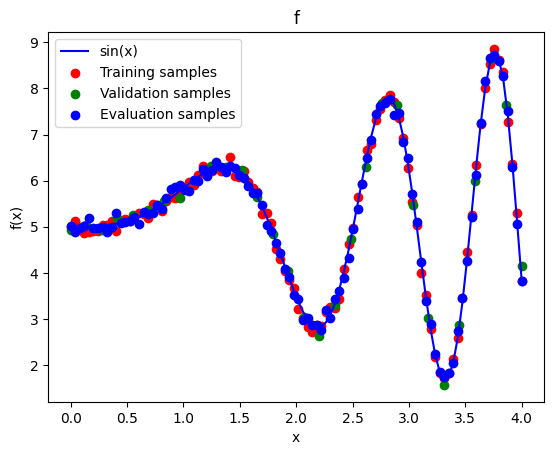

In [10]:
# Generates n samples of f(x) for values of x between x0 and x1
# Sample has gaussian noise with standard deviation std_dev
def noisey_sample(f, x0, x1, n, std_dev):
    x = np.linspace(x0, x1, n)
    y = np.vectorize(f)(x)
    noise = np.random.normal(0, std_dev, n)
    return x, y + noise


# f = lambda x: np.sin(x ** 2) * x
# x0 = 0 # -4
# x1 = 4 # 2 * np.pi
# n = 100

x_original = np.linspace(x0, x1, n)
y_original = np.vectorize(f)(x_original)
plt.plot(x_original, y_original, label="sin(x)", color="blue")

training = noisey_sample(f, x0, x1, 100, 0.1)
validation = noisey_sample(f, x0, x1, 30, 0.1)
evaluation = noisey_sample(f, x0, x1, 100, 0.1)
# Plot the sine wave
plt.scatter(training[0], training[1], color="red", label="Training samples")
plt.scatter(validation[0], validation[1], color="green", label="Validation samples")
plt.scatter(evaluation[0], evaluation[1], color="blue", label="Evaluation samples")


# Add title and labels
plt.title("f")
plt.xlabel("x")
plt.ylabel("f(x)")

plt.legend()

# Display the plot
plt.show()

In [11]:
print(torch.get_default_device())

cpu


## TODO

* Write introduction.
  * Goals.
  * Overview.
* Write prerequisites.
* Explain matrix math and impact of removing relu.
* Function to calculate error - used for evaluation.
* Display error for python model and pytorch model.
* Train pytorch model on f.
  * Show how model evolves over time.
* Train pytorch model on f with noise.
  * Show how model evolves over time.
  * Show overfitting.

$\hat{Y} = \hat{\beta}_{0} + \sum \limits _{j=1} ^{p} X_{j}\hat{\beta}_{j} $

In [12]:
# %matplotlib widget
# import numpy as np
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# # Generate some data for the height field
# x = np.linspace(-5, 5, 100)
# y = np.linspace(-5, 5, 100)
# X, Y = np.meshgrid(x, y)
# Z = np.sin(np.sqrt(X**2 + Y**2))

# # Create a figure and 3D axes
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # Plot the surface
# surf = ax.plot_surface(X, Y, Z, cmap='viridis')

# # Add labels and title
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Height')
# plt.title('3D Height Field')

# # Show the plot
# plt.show()